# Load module

In [1]:
import sys
sys.path.append('../')

from ssd_data import datasets
from ssd_data import transforms, target_transforms, augmentations, utils

from ssd.models.ssd300 import SSD300
from ssd.train import *

#from torchvision import transforms > not import!!
from torch.utils.data import DataLoader
from torch.optim.sgd import SGD
from torch.optim.adam import Adam

# Load COCO Dataset

In [2]:
augmentation = augmentations.AugmentationOriginal()
#augmentation = None
transform = transforms.Compose(
    [transforms.Resize((300, 300)),
     transforms.ToTensor(),
     transforms.Normalize(rgb_means=(0.485, 0.456, 0.406), rgb_stds=(0.229, 0.224, 0.225))]
)
target_transform = target_transforms.Compose(
    [target_transforms.ToCentroids(),
     target_transforms.OneHot(class_nums=datasets.COCO_class_nums, add_background=True),
     target_transforms.ToTensor()]
)
train_dataset = datasets.COCO2014_TrainValDataset(ignore=target_transforms.Ignore(iscrowd=True), transform=transform, target_transform=target_transform, augmentation=augmentation)

train_loader = DataLoader(train_dataset,
                          batch_size=32,
                          shuffle=True,
                          collate_fn=utils.batch_ind_fn,
                          num_workers=4,
                          pin_memory=True)
print('{} training images'.format(len(train_dataset)))

loading annotations into memory...
Done (t=5.74s)
creating index...
index created!
loading annotations into memory...
Done (t=2.56s)
creating index...
index created!
122218 training images


# Define model

In [3]:
model = SSD300(class_labels=train_dataset.class_labels, batch_norm=False).cuda()
model.load_vgg_weights()
print(model)

SSD300(
  (codec): Codec(
    (encoder): Encoder()
    (decoder): Decoder()
  )
  (defaultBox): DBoxSSDOriginal()
  (predictor): Predictor()
  (inferenceBox): InferenceBox()
  (feature_layers): ModuleDict(
    (convRL1_1): ConvRelu(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (convRL1_2): ConvRelu(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (convRL2_1): ConvRelu(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (convRL2_2): ConvRelu(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (convRL3

# Set matplotlib for Jupyter notebook

In [4]:
%matplotlib notebook

# Train COCO

<IPython.core.display.Javascript object>


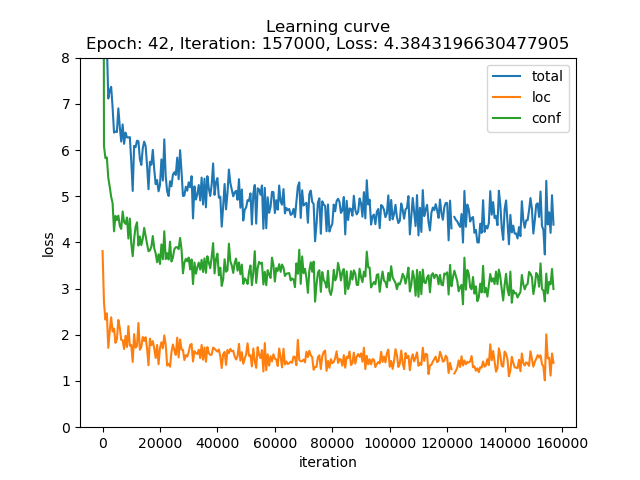

Training... Epoch: 3, Iter: 10000,	 [75520/122218	 (62%)]	Loss: 5.758370, Loc Loss: 1.780539, Conf Loss: 3.977831	Iter time: 0.24519
Saved model to /home/kado/Desktop/program/machile-learning/pytorch_SSD/weights/checkpoints/ssd300-COCO_i-0010000_checkpoints20200609.pth

Training... Epoch: 6, Iter: 20000,	 [28800/122218	 (24%)]	Loss: 5.245222, Loc Loss: 1.712387, Conf Loss: 3.532835	Iter time: 0.265531
Saved model to /home/kado/Desktop/program/machile-learning/pytorch_SSD/weights/checkpoints/ssd300-COCO_i-0020000_checkpoints20200609.pth

Training... Epoch: 8, Iter: 30000,	 [104320/122218	 (85%)]	Loss: 5.300249, Loc Loss: 1.628258, Conf Loss: 3.671991	Iter time: 0.27061
Saved model to /home/kado/Desktop/program/machile-learning/pytorch_SSD/weights/checkpoints/ssd300-COCO_i-0030000_checkpoints20200609.pth

Training... Epoch: 11, Iter: 40000,	 [57600/122218	 (47%)]	Loss: 5.392380, Loc Loss: 1.635809, Conf Loss: 3.756570	Iter time: 0.283029
Saved model to /home/kado/Desktop/program/machile-

In [ ]:
optimizer = SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4) # late and not converge.
#optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
iter_sheduler = SSDIterMultiStepLR(optimizer, milestones=(160000, 200000), gamma=0.1, verbose=True)

save_manager = SaveManager(modelname='ssd300-COCO', interval=10000, max_checkpoints=15, plot_yrange=(0, 8))
log_manager = LogManager(interval=500, save_manager=save_manager, loss_interval=500, live_graph=LiveGraph((0, 8)))
trainer = TrainLogger(model, loss_func=SSDLoss(), optimizer=optimizer, scheduler=iter_sheduler, log_manager=log_manager)

#trainer.train(70, train_loader)
trainer.train(240000, train_loader)

# mAP calculation

In [ ]:
import sys
sys.path.append('../')

from ssd_data import datasets
from ssd_data import transforms, target_transforms, augmentations, utils

from ssd.models.ssd300 import SSD300
from ssd.train import *

#from torchvision import transforms > not import!!
from torch.utils.data import DataLoader

transform = transforms.Compose(
    [transforms.Resize((300, 300)),
     transforms.ToTensor(),
     transforms.Normalize(rgb_means=(0.485, 0.456, 0.406), rgb_stds=(0.229, 0.224, 0.225))]
)
target_transform = target_transforms.Compose(
    [target_transforms.ToCentroids(),
     target_transforms.OneHot(class_nums=datasets.VOC_class_nums, add_background=True),
     target_transforms.ToTensor()]
)


test_dataset = datasets.VOC2007_TestDataset(transform=transform, target_transform=target_transform)
test_loader = DataLoader(test_dataset,
                          batch_size=32,
                          shuffle=False,
                          collate_fn=utils.batch_ind_fn,
                          num_workers=4,
                          pin_memory=True)

model = SSD300(class_labels=test_dataset.class_labels, batch_norm=False).cuda()
model.load_weights('../weights/ssd300-voc2007+2012/ssd300-voc2007+2012_i-80000.pth')
model.eval()

evaluator = VOC2007Evaluator(test_loader)
ap = evaluator(model)
print(ap)